### 数据集构建

In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from utils.dataset_utils import get_classes_indexes_counts
import scipy.io as sio  # 从.mat文件中读取数据集
import numpy as np

################################################################加载数据集################################################
# 数据集
mat_data = sio.loadmat('../../data/dataset/LedDisplay.mat')
# 提取变量
dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]
# 显示数据集分布
print("特征数据:", dataset_x.shape)
print("label:", dataset_y.shape)

# One-hot encode target variable 强制将类别转换为0，1，2，3......
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(dataset_y.reshape(-1, 1))


# 统计每个类别的个数，dataset_y.max()+1是类别的个数
classes, counts = get_classes_indexes_counts(dataset_y)
print("每种类别的数量：", counts)

特征数据: (1000, 24)
label: (1000,)
每种类别的数量： [103  89 116 114 116  86 107  97  83  89]


###  划分数据集

In [2]:
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(dataset_x, y_onehot, test_size=0.3, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

# 显示数据集分布
print("特征数据:", x_train.shape)
print("label:", y_train.shape)

# 统计每个类别的个数 np.argmax(y_train, axis=1) Convert one-hot encoded test labels back to single class labels
classes_train, counts_train = get_classes_indexes_counts(np.argmax(y_train, axis=1))
print("训练集每种类别的数量：", counts_train)

classes_test, counts_test = get_classes_indexes_counts(np.argmax(y_test, axis=1))
print("测试集每种类别的数量：", counts_test)

特征数据: (700, 24)
label: (700, 10)
训练集每种类别的数量： [67 68 79 79 81 63 71 63 63 66]
测试集每种类别的数量： [36 21 37 35 35 23 36 34 20 23]


### 训练集的构建
1.首先找出类别数量最小的类
2.取最小类别数量的90%，作为平衡数据集的各类别原始数量
3.在每个类别中随机抽取实例构成初始数据集

In [3]:
# 确定每个类别的数量
num_instances = int(counts_train.min() * 0.9)  # 向下取整
print("最小数量:", num_instances)

# 在每个类别中随机的选择该数量的实例的索引
balanced_classes = np.array([])
for indexes in classes_train:
    random_selecte_indices = np.random.choice(indexes, size=num_instances, replace=False)
    balanced_classes = np.hstack((balanced_classes, random_selecte_indices))
balanced_classes = np.sort(balanced_classes).astype(int)

# 得到平衡的数据集
balanced_dataset_x = []
balanced_dataset_y = []
for index in balanced_classes:
    balanced_dataset_x.append(x_train[index])
    balanced_dataset_y.append(y_train[index,:])
balanced_dataset_x = np.array(balanced_dataset_x)
balanced_dataset_y = np.array(balanced_dataset_y).astype(int)

# 显示数据集分布
print("平衡的数据集的特征数据:", balanced_dataset_x.shape)
print("label:", balanced_dataset_y.shape)

# 统计每个类别的个数
classes_balanced_dataset, counts_balanced_dataset = get_classes_indexes_counts(np.argmax(balanced_dataset_y, axis=1))
print("平衡的数据集中每种类别的数量：", counts_balanced_dataset)

最小数量: 56
平衡的数据集的特征数据: (560, 24)
label: (560, 10)
平衡的数据集中每种类别的数量： [56 56 56 56 56 56 56 56 56 56]


### 评价目标

In [4]:
from scipy.stats import gmean
import math
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, auc,roc_auc_score
import matplotlib.pyplot as plt

##########################由个体得到选择的实例子集的索引###########################
def get_indices(individual):
    '''
    :param individual: individual（用实值进行编码）
    :return: 被选择实例的索引
    '''
    individual = np.round(individual)  # 数据范围在0-1之间，转化成int的同时会舍去小数部分，从而将个体映射到0-1编码
    indices = np.where(individual == 1)  # 1代表选择该实例，返回值是tuple，tuple[0]取元组中的第一个元素
    return indices[0]


###########################获取实例子集############################
def get_subset(individual):
    '''
    :param individual: 
    :return: 实例子集
    '''
    indices = get_indices(individual)
    x_sub = balanced_dataset_x[indices, :]
    y_sub = balanced_dataset_y[indices, :]
    return x_sub, y_sub


##########################适应度函数（PPV和PFC，为主要、次要指标）#################################
def fitness_function(x_sub, y_sub, ensembles, index):
    ######################PPV#######################
    # 使用训练数据进行预测
    index_pred = ensembles[index].predict(x_sub) # 计算accuracy、PPV
    index_pred_proba = ensembles[index].predict_proba(x_sub) # 计算mAUC
    
    # Convert one-hot encoded test labels back to single class labels
    y_test_labels = np.argmax(y_sub, axis=1)
    y_pred_labels = np.argmax(index_pred, axis=1)
    _, counts=get_classes_indexes_counts(y_test_labels)
    print("类型数量",len(counts))
    # 计算每个类别的 Precision
    class_precisions = precision_score(y_test_labels, y_pred_labels, average=None)
    print("每个类别的PPV：", class_precisions)
    geometric_mean=gmean(class_precisions)
    ######################PFC#######################
    
    # Compute AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(y_onehot.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_sub[:, i], index_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_onehot.shape[1])]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(y_onehot.shape[1]):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= y_onehot.shape[1]
    macro_auc = auc(all_fpr, mean_tpr)
    
    # Plot AUC curves
    plt.figure(figsize=(8, 6))
    for i in range(y_onehot.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot(all_fpr, mean_tpr, label=f'Macro-average (AUC = {macro_auc:.2f})', linestyle='--', color='navy')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    #plt.show()
    
    return round(geometric_mean, 4), round(macro_auc, 4)



### 多目标评价

D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\n

类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
gen	evals	min      	max      
0  	5    	[ 1. nan]	[ 1. nan]


D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\n

类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
1  	5    	[ 1. nan]	[ 1. nan]


D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\IDE\Anaconda\envs\pytorch\lib\site-packages\sklearn\n

类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1.]
类型数量 10
每个类别的PPV： [1. 1. 1. 1. 1. 1. 1. 1. 1.]
2  	5    	[ 1. nan]	[ 1. nan]


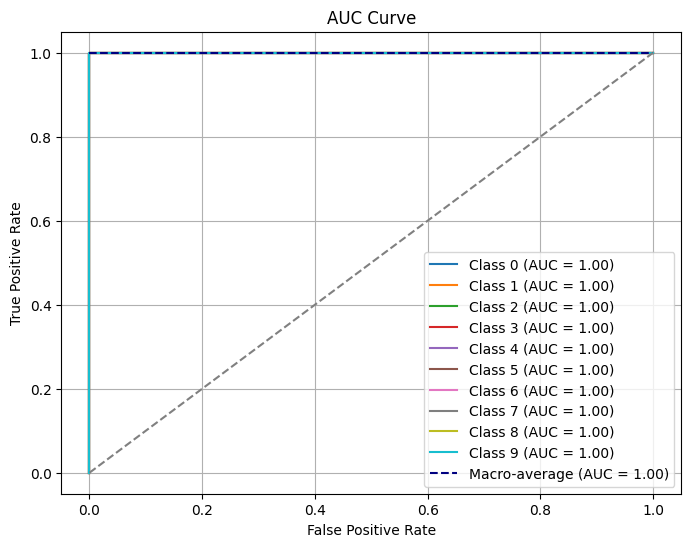

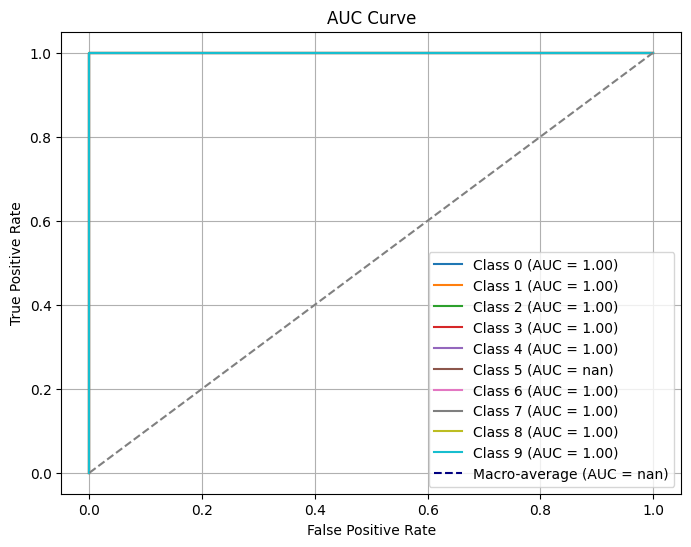

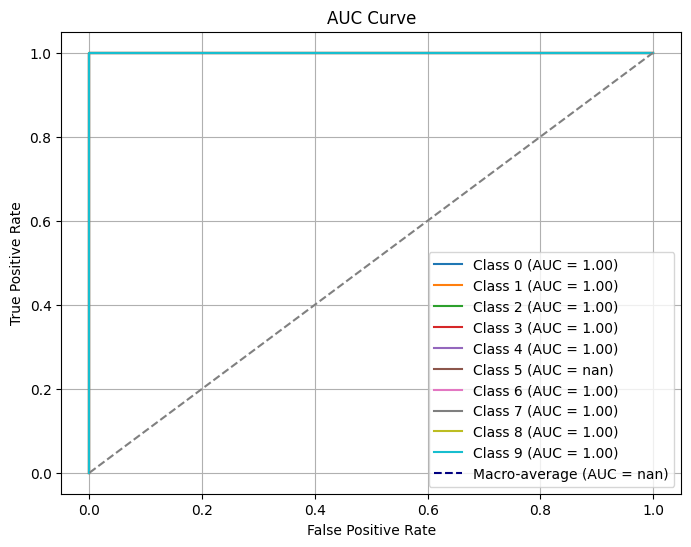

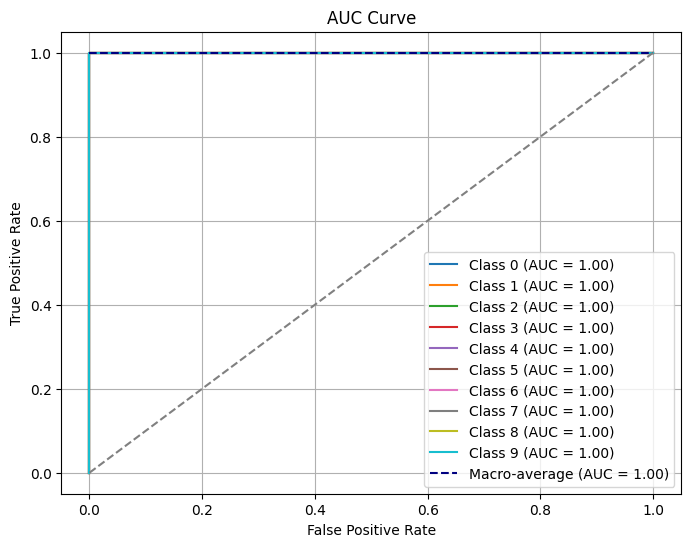

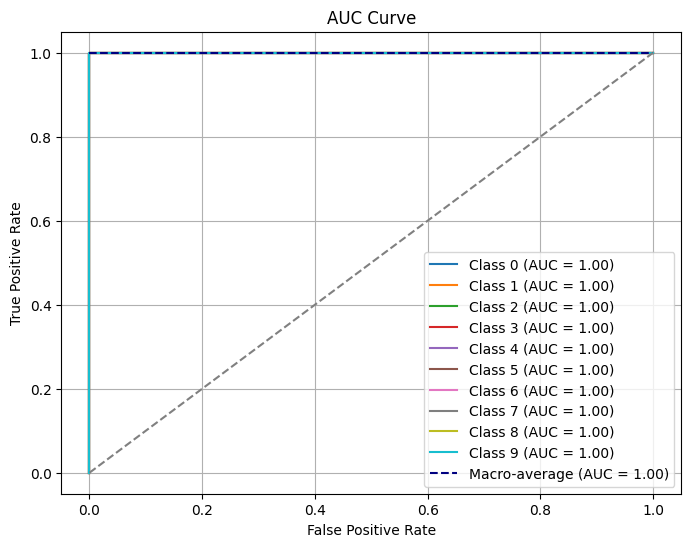

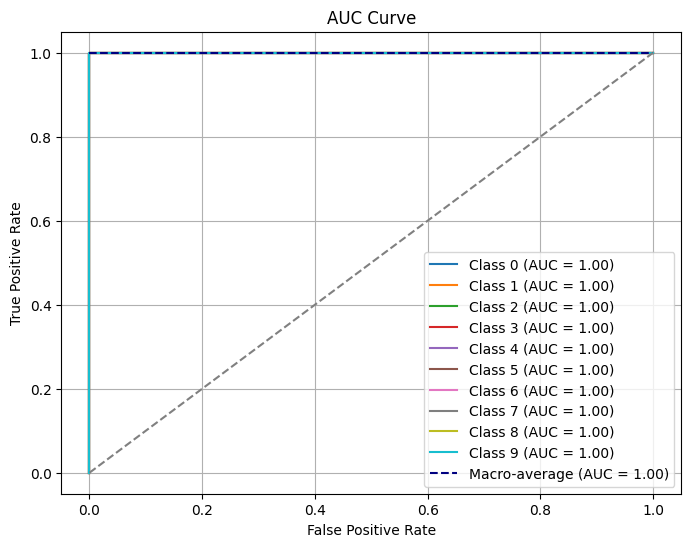

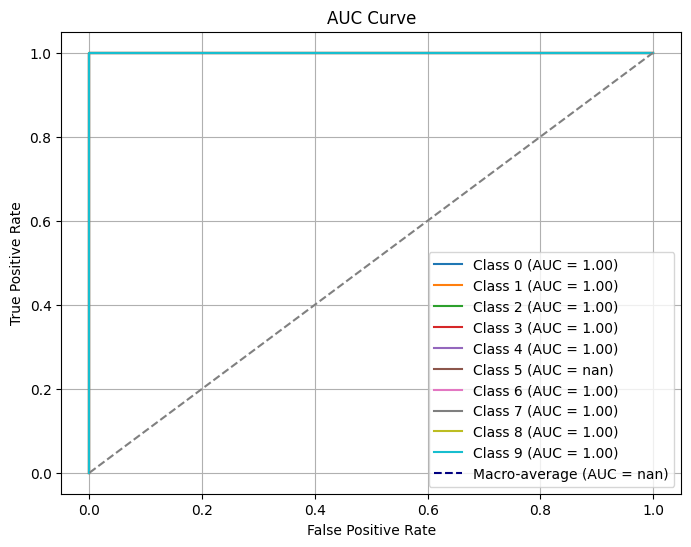

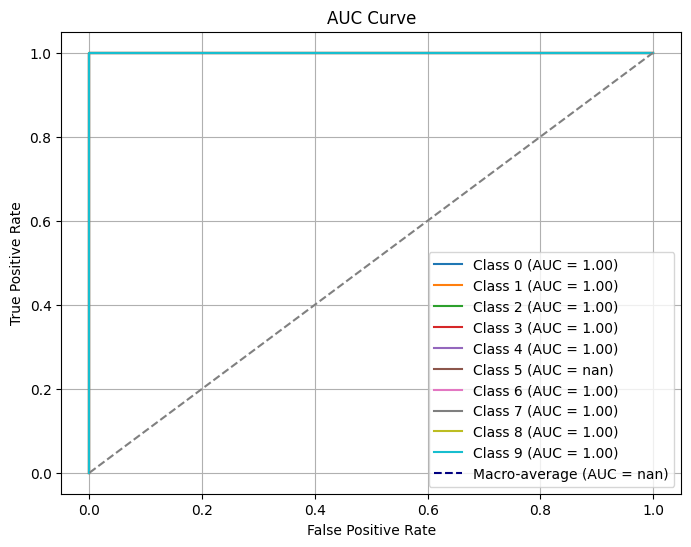

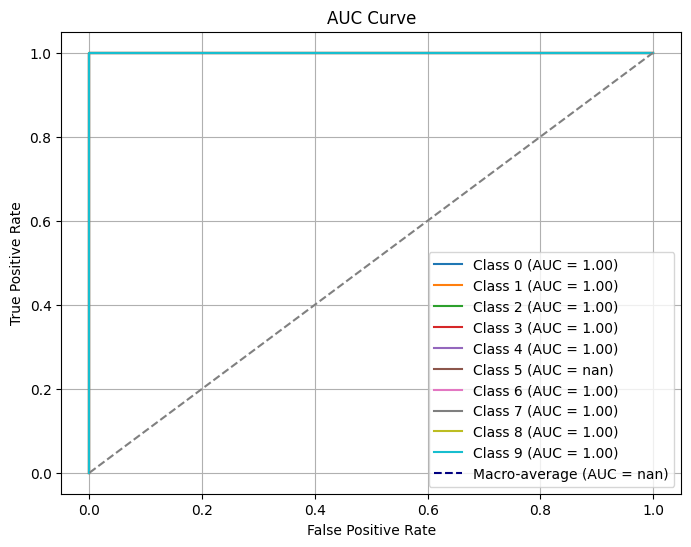

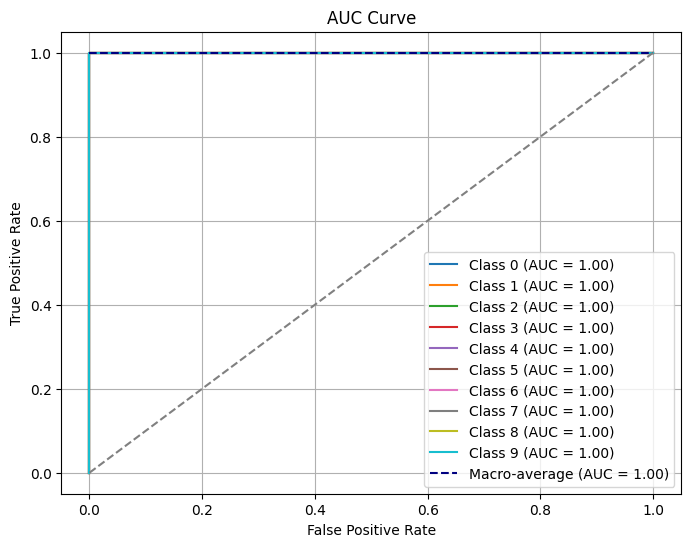

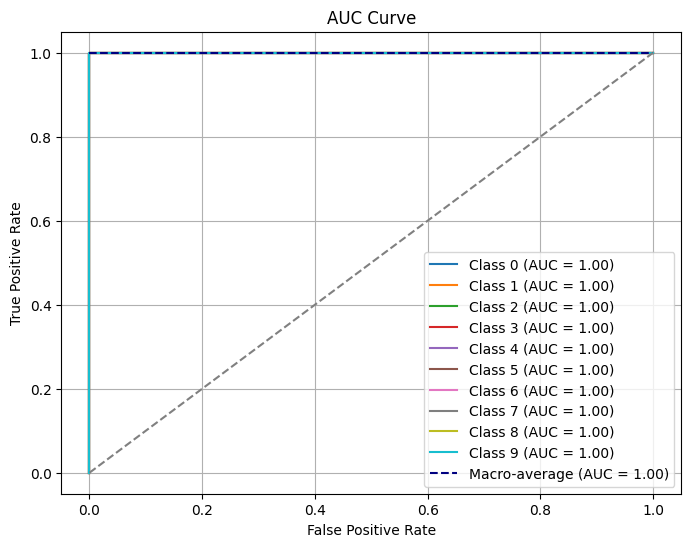

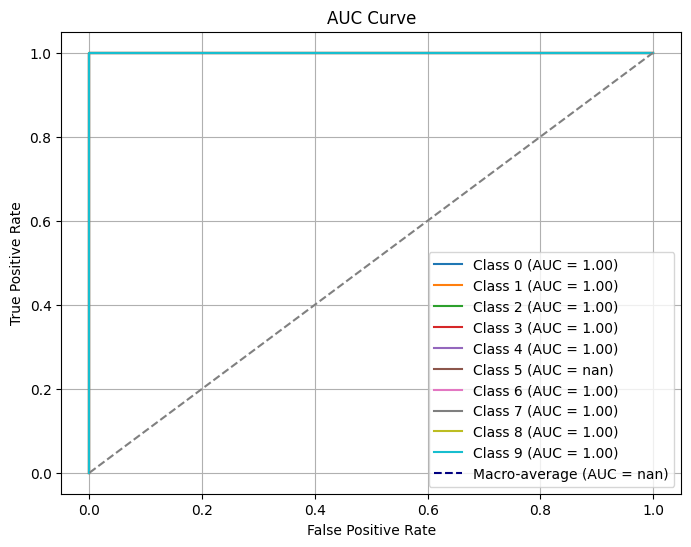

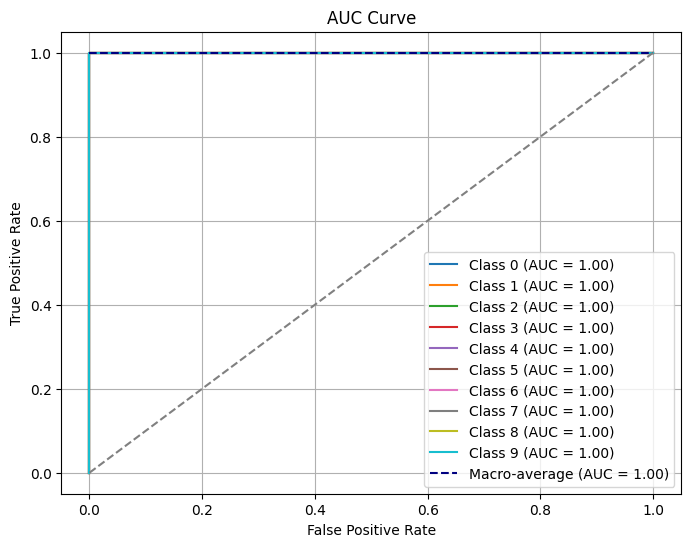

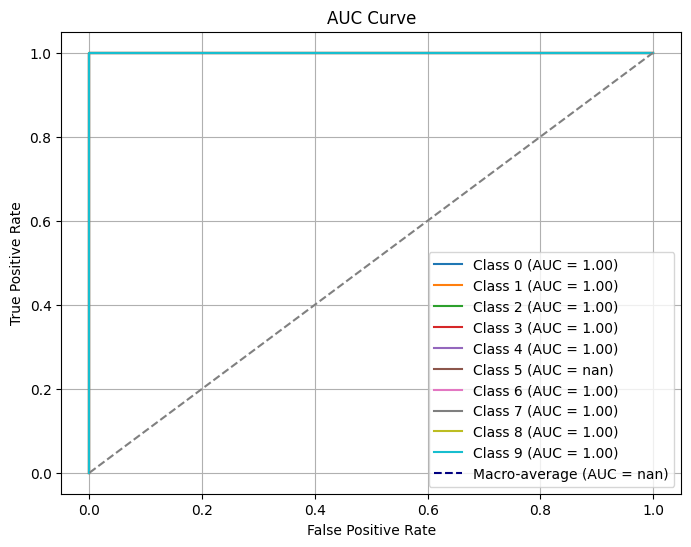

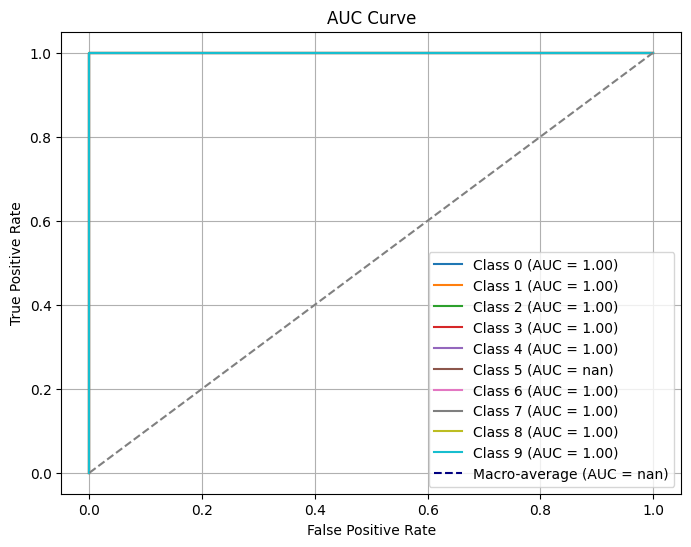

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
import array
import random
import numpy
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMaxAndMax", base.Fitness, weights=(1.0, 1.0))
'''
fitness:适应度：Gmean和mAUC
class_accuracies：分类器对每个类的分类准确度
PPVs：PPV也即Precision,PPVs表示对每个类的分类精度
PFC：每个分类器的成对故障信用，用于评估分类器集合的多样性

'''
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMaxAndMax, PFC=None)
toolbox = base.Toolbox()

# Problem definition

BOUND_LOW, BOUND_UP = 0.0, 1.0

NDIM = num_instances


toolbox.register("attr_binary", random.randint, 0, 1) # 0-1编码
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_binary, n=num_instances)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# toolbox.register("evaluate", benchmarks.zdt1)
toolbox.register("evaluate", fitness_function)
# toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0 / NDIM)
# toolbox.register("select", tools.selNSGA2)
toolbox.register("select", tools.selTournament, tournsize=3)

init_mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=800, random_state=42)


def main(seed=None):
    random.seed(seed)

    NGEN = 3
    MU = 5
    CXPB = 0.9

    ####################################迭代过程的记录###########################
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "min", "max"

    ####################################种群的初始化###########################
    pop = toolbox.population(n=MU)
    
    ####################################计算初始种群的适应度###########################
    ensembles = []  # 当前每个个体对应的mlp模型
    base_estimators = [] # 基学习器
    save_ensemble = None  # 存储每个个体对应的mlp模型
    pop_x_sub = []  # 当前每个个体的实例选择的特征数据
    pop_y_sub = []  # 当前每个个体对应的实例选择的lable
    # 对于每个个体都训练得到一个mlp模型
    for i in range(len(pop)):
        mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=800, random_state=42)
        x_sub, y_sub = get_subset(pop[i])
        mlp.fit(x_sub, y_sub)
        ensembles.append(mlp)
        pop_x_sub.append(x_sub)
        pop_y_sub.append(y_sub)
    
    # 由mlp模型得到个体的适应度
    for i in range(len(pop)):
        pop[i].fitness.values = toolbox.evaluate(pop_x_sub[i], pop_y_sub[i], ensembles, i)
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(pop), **record)
    print(logbook.stream)
    ####################################种群的迭代###########################
    for gen in range(1, NGEN):
        # 选择
        offspring = toolbox.select(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        # 交叉
        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])
            # 突变
            offspring[i] = toolbox.mutate(offspring[i])[0]
            offspring[i + 1] = toolbox.mutate(offspring[i + 1])[0]
            del offspring[i].fitness.values, offspring[i + 1].fitness.values

        # 计算新的种群适应度 
        ensembles.clear()
        pop_x_sub.clear()
        pop_y_sub.clear()
        for i in range(len(offspring)):
            mlp = MLPClassifier(hidden_layer_sizes=(20,), max_iter=800, random_state=42)
            x_sub, y_sub = get_subset(offspring[i])
            mlp.fit(x_sub, y_sub)
            ensembles.append(mlp)
            pop_x_sub.append(x_sub)
            pop_y_sub.append(y_sub)
        for i in range(len(offspring)):
            offspring[i].fitness.values = toolbox.evaluate(pop_x_sub[i], pop_y_sub[i], ensembles, i)

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), **record)
        print(logbook.stream)

    return pop, logbook


if __name__ == "__main__":
    pop, stats = main()
